In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 # for image resizing
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
print(tf.__version__)

Using TensorFlow backend.


1.10.0


In [108]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback

In [2]:
from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 46s 1us/step


In [91]:
train_dir = './dataset/train'
validation_dir = './dataset/validation'

 
nTrain = 672
nVal = 224

In [101]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,2))
 
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_features = np.zeros(shape=(nVal, 7, 7, 512))
val_labels = np.zeros(shape=(nVal,2))
 
val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 672 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


In [102]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
         
#train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

In [103]:
i=0
for inputs_batch, labels_batch in val_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    val_features[i * batch_size : (i + 1) * batch_size] = features_batch
    val_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break
         
#val_features = np.reshape(val_features, (nVal, 7 * 7 * 512))

In [97]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same", input_shape=(7 , 7 , 512)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = optimizers.Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 7, 7, 64)          294976    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               295424    
_________________________________________________________________
dense_67 (Dense)             (None, 256)               131328    
__________

In [98]:
history = model.fit(train_features,
                    train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(val_features,val_labels),callbacks=[chkpt])

Train on 672 samples, validate on 224 samples
Epoch 1/50
672/672 [==============================] - 123s 183ms/step - loss: 0.6584 - acc: 0.6562 - val_loss: 0.6674 - val_acc: 0.6295
Epoch 2/50
672/672 [==============================] - 1s 1ms/step - loss: 0.6289 - acc: 0.6696 - val_loss: 0.6489 - val_acc: 0.6295
Epoch 3/50
672/672 [==============================] - 1s 861us/step - loss: 0.6204 - acc: 0.6845 - val_loss: 0.6428 - val_acc: 0.6295
Epoch 4/50
672/672 [==============================] - 1s 1ms/step - loss: 0.5899 - acc: 0.6830 - val_loss: 0.6536 - val_acc: 0.6295
Epoch 5/50
672/672 [==============================] - 1s 895us/step - loss: 0.5866 - acc: 0.6741 - val_loss: 0.6296 - val_acc: 0.6384
Epoch 6/50
672/672 [==============================] - 1s 1ms/step - loss: 0.5356 - acc: 0.7247 - val_loss: 0.6071 - val_acc: 0.6786
Epoch 7/50
672/672 [==============================] - 1s 1ms/step - loss: 0.5097 - acc: 0.7500 - val_loss: 0.6253 - val_acc: 0.6652
Epoch 8/50
672/672 [==

In [104]:
model.load_weights("best_model_todate")

In [105]:
fnames = val_generator.filenames
 
ground_truth = val_generator.classes
 
label2index = val_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(val_features)
prob = model.predict(val_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 70/224


In [106]:
fnames = train_generator.filenames
 
ground_truth = train_generator.classes
 
label2index = train_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(train_features)
prob = model.predict(train_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nTrain))

No of errors = 35/672


Original label:0\107. 300px-peter_trego_batting.jpg, Prediction :1, confidence : 0.501


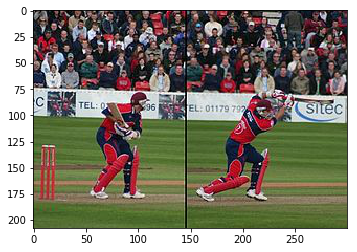

Original label:0\108. 9d29fc20d1ad8eb331992ca310fc125b.jpg, Prediction :1, confidence : 0.701


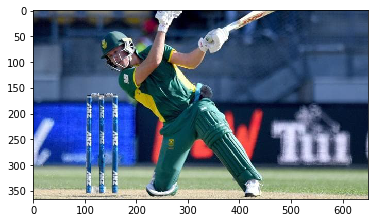

Original label:0\110. 12stdr4.jpg, Prediction :1, confidence : 0.628


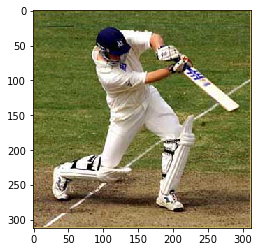

Original label:0\117. cricket_batting_techniques_1_decathlon.jpg, Prediction :1, confidence : 0.603


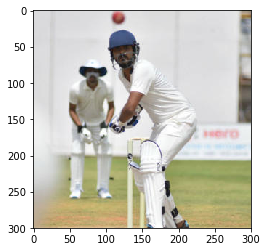

Original label:0\131. 12glan4.jpg, Prediction :1, confidence : 0.753


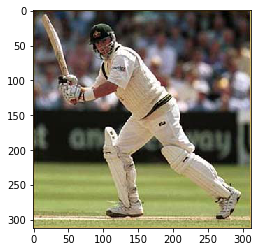

Original label:0\15. 12fdef4.jpg, Prediction :1, confidence : 0.763


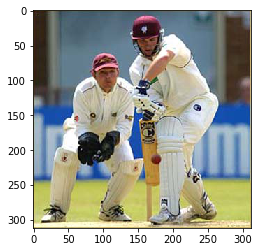

Original label:0\156. slide2.jpg, Prediction :1, confidence : 0.619


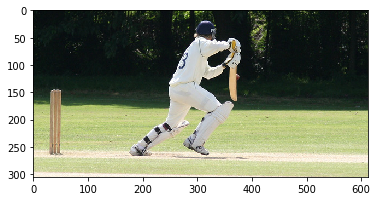

Original label:0\16. 200px-ricky_ponting.jpg, Prediction :1, confidence : 0.657


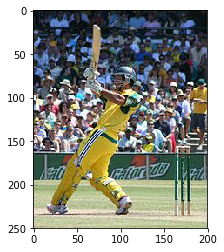

Original label:0\16. cricket-shots.jpg, Prediction :1, confidence : 0.675


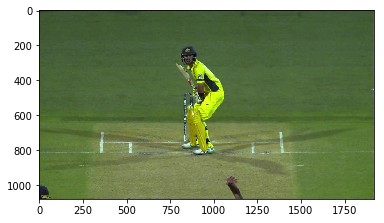

Original label:0\22. slide1.jpg, Prediction :1, confidence : 0.591


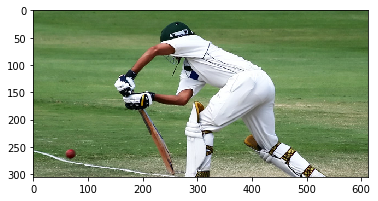

Original label:0\25. 260px-master_blaster_at_work.jpg, Prediction :1, confidence : 0.756


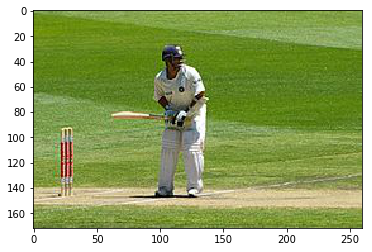

Original label:0\39. 12cdef1.jpg, Prediction :1, confidence : 0.686


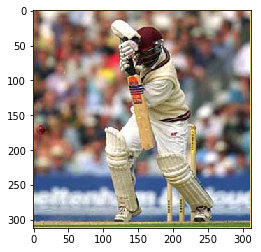

Original label:0\46. how_to_play_a_back_foot_defence_en_hd.jpg, Prediction :1, confidence : 0.842


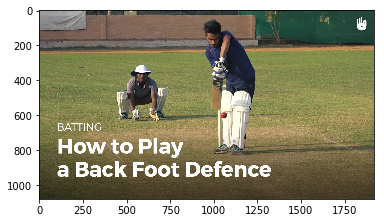

Original label:0\48. tfc041.png, Prediction :1, confidence : 0.638


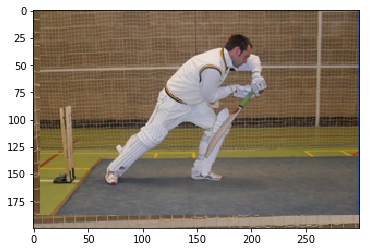

Original label:0\52. batting_shot-on-drive-199x300.jpg, Prediction :1, confidence : 0.585


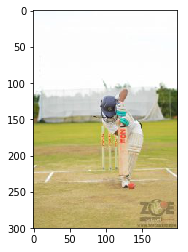

Original label:0\54. maxresdefault.jpg, Prediction :1, confidence : 0.626


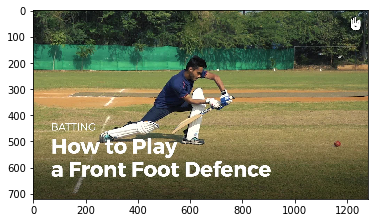

Original label:0\57. 594611-kohli-six.jpg, Prediction :1, confidence : 0.642


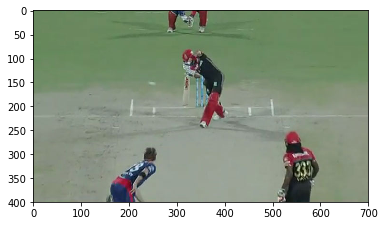

Original label:0\64. 12sq4.jpg, Prediction :1, confidence : 0.510


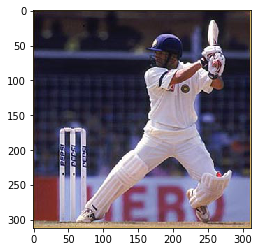

Original label:0\64. 300px-peter_trego_batting.jpg, Prediction :1, confidence : 0.501


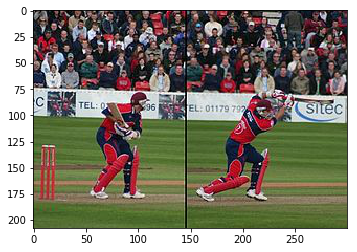

Original label:0\71. th10_sachin.jpg, Prediction :1, confidence : 0.580


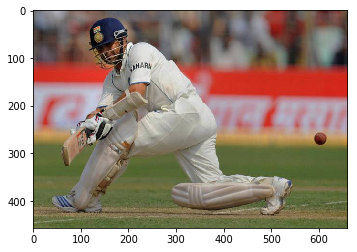

Original label:0\74. aid469082-v4-728px-play-various-shots-in-cricket-step-6-version-4.jpg, Prediction :1, confidence : 0.637


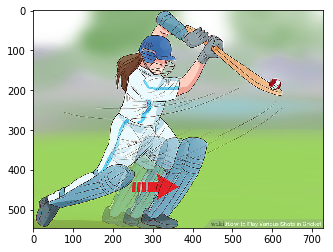

Original label:0\76. 250px--this_is_batting.ogv.jpg, Prediction :1, confidence : 0.546


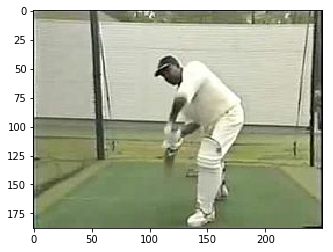

Original label:0\87. 3033798.jpg, Prediction :1, confidence : 0.510


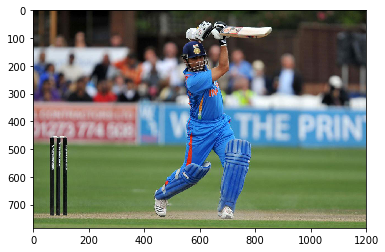

Original label:0\88. play-various-shots-in-cricket-step-13.jpg, Prediction :1, confidence : 0.538


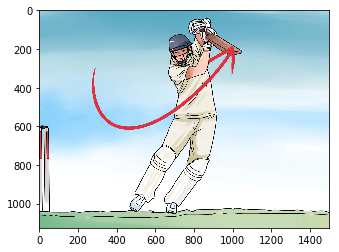

Original label:0\9. aid469082-v4-728px-play-various-shots-in-cricket-step-10-version-3.jpg, Prediction :1, confidence : 0.574


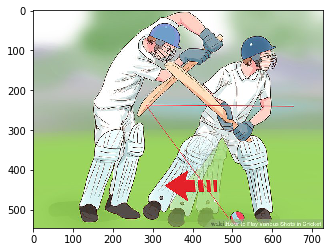

Original label:0\90. sharma4imrpoved.jpg, Prediction :1, confidence : 0.543


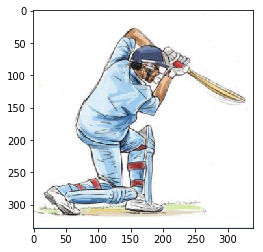

Original label:1\114. 576921-ab-de-villiers-grab.jpg, Prediction :0, confidence : 0.541


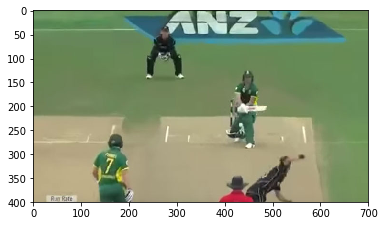

Original label:1\169. maxresdefault.jpg, Prediction :0, confidence : 0.577


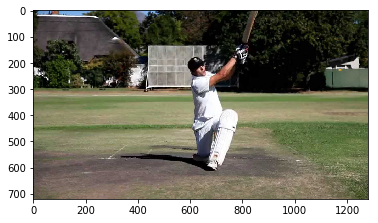

Original label:1\35. aid469082-v4-728px-play-various-shots-in-cricket-step-5-version-4.jpg, Prediction :0, confidence : 0.519


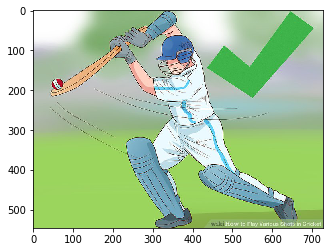

Original label:1\4. main-qimg-a7f70ec764558c486cb3cec670a779a3-c.jpg, Prediction :0, confidence : 0.652


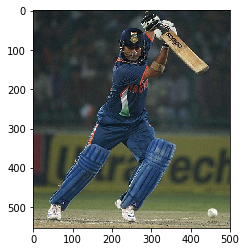

Original label:1\442. aid469082-v4-728px-play-various-shots-in-cricket-step-13-version-3.jpg, Prediction :0, confidence : 0.587


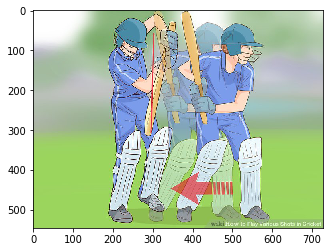

Original label:1\477. ab-de-villiers-innovative-cricket-shots.jpg, Prediction :0, confidence : 0.530


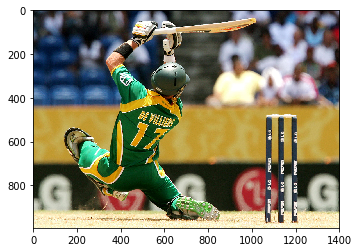

Original label:1\60. 180px-jonathan_trott.jpg, Prediction :0, confidence : 0.580


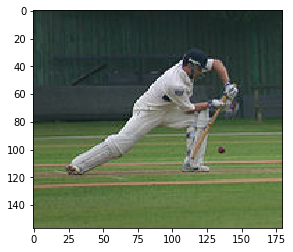

Original label:1\73. batting-front-foot-defence_right-hand-batsman-281x300.jpg, Prediction :0, confidence : 0.507


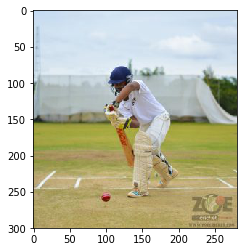

Original label:1\79. fb600_1488786254.jpg, Prediction :0, confidence : 0.537


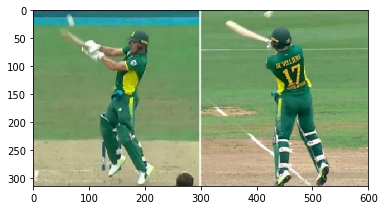

In [113]:
#Visualising errors, most are caused because dataset is not very well prepared
num_errors = int(len(errors))
for i in range(num_errors):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
     
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
     
    original = load_img('{}/{}'.format(train_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()